# _Notebook Jupyter_ 3_classificarAplicação

# Classificação dos modelos de motocicleta a partir da descrição

A grande dificuldade na tarefa de análise de valores compatíveis na importação de peças de motocicletas, em especial dos kits de transmissão, se dá no fato de que milhares de importadores adquirem essas peças no exterior e informam sua descrição em um campo texto livre.<br>
Nem mesmo a utilização da classificação fiscal normatizada no Mercosul, chamada de Nomenclatura Comum do Mercosul – NCM, ajuda nesse caso específico, tendo em vista que grande parte das peças de motocicletas e todos os kits de transmissão são classificados em uma mesma posição na tabela da NCM.<br>
Para que se possa tratar corretamente o dataset obtido na nossa etapa de processamento e tratamento de dados, e permitir o futuro aprendizado de máquina, com predições do modelo de motocicleta que aquele item se aplica, é preciso que primeiro se proceda a uma classificação de aplicações que futuramente será utilizado em um aprendizado supervisionado.<br>
A ideia é se aplicar uma busca na descrição da mercadoria pelos termos conhecidos de aplicações e se buscar a qual aplicação aquela descrição se refere, fazendo desse modo a primeira classificação.<br>
Posteriormente será utilizado um algorítimo de aprendizado de máquina para aprender com o próprio texto da descrição da aplicação e fazer a classificação utilizando a descrição já limpa de stopwords e outros termos desnecessários.<br>
A interseção dos dois conjuntos de classificação será o dataset utilizado para fazer o treinamento do classificador, que será o primeiro passo antes da análise de valor do item importado.

### Importa as bibliotecas necessárias

In [1]:
import pandas as pd, numpy as np
import re, time
# stopwords
from nltk.corpus import stopwords
# wordcloud
from wordcloud import WordCloud
# plotagem do gráfico
import matplotlib.pyplot as plt

In [2]:
# Data e hora da execução do script
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 10/01/2022 às 19:13


### Importa os dados já tratados

In [3]:
# Importa base de dados para um dataframe
df = pd.read_excel(r'./bases/dataframe.xlsx')

In [4]:
# Verifica o tamnanho do dataframe
df.shape

(19092, 25)

In [5]:
# Mostra linhas de exemplo do dataframe
df.sample(5)

,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS.OR,PAIS DE ORIGEM,PAIS.AQ,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,...,VL FRETE DOLAR,VL SEGURO DOLAR,VALOR UN.PROD.DOLAR,QTD COMERCIAL.,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO
14745,343810000100011,202103,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",160,"CHINA, REPUBLICA POP",10,QUILOGRAMA LIQUIDO,...,26400.00,0.00,2.956300,250.0,739.07500,N/INFORMADO,ITAJAI,FOB,EFETIVA,DI DESEMBARAÇADA
3602,736560000100025,202006,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",767,SUICA,10,QUILOGRAMA LIQUIDO,...,2412.44,0.00,4.848000,200.0,969.60000,N/INFORMADO,ALF - SALVADOR,FOB,EFETIVA,DI DESEMBARAÇADA
2342,1199200000100016,202003,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",160,"CHINA, REPUBLICA POP",10,QUILOGRAMA LIQUIDO,...,9250.00,159.18,3.720000,300.0,1116.00000,N/INFORMADO,PORTO DE SANTOS,FOB,EFETIVA,DI DESEMBARAÇADA
8776,934180000100004,202010,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",160,"CHINA, REPUBLICA POP",10,QUILOGRAMA LIQUIDO,...,2059.18,98.30,3.744278,100.0,374.42784,N/INFORMADO,ITAJAI,CIF,EFETIVA,DI DESEMBARAÇADA
17718,854830000500047,202105,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",767,SUICA,10,QUILOGRAMA LIQUIDO,...,20050.30,343.14,5.796000,1000.0,5796.00000,N/INFORMADO,ITAJAI,FOB,EFETIVA,DI DESEMBARAÇADA


In [6]:
# Remove espaços em excesso das colunas do tipo string
colstr = ['DESCRICAO DO CODIGO NCM',
          'PAIS DE ORIGEM',
          'PAIS DE AQUISICAO',
          'UNIDADE DE MEDIDA',
          'UNIDADE COMERC.',
          'DESCRICAO DO PRODUTO',
          'UNIDADE DESEMBARQUE',
          'UNIDADE DESEMBARACO',
          'INCOTERM',
          'NAT.INFORMACAO',
          'SITUACAO DO DESPACHO']
for coluna in colstr:
    df[coluna]=df[coluna].str.strip()

In [7]:
for col in df.columns:
    if type(df[col][1])==str:
        print(col)
        df[col]=df[col].str.strip()

DESCRICAO DO CODIGO NCM
PAIS DE ORIGEM
PAIS DE AQUISICAO
UNIDADE DE MEDIDA
UNIDADE COMERC.
DESCRICAO DO PRODUTO
UNIDADE DESEMBARQUE
UNIDADE DESEMBARACO
INCOTERM
NAT.INFORMACAO
SITUACAO DO DESPACHO


In [8]:
df['DESCRICAO DO PRODUTO'][5]

'80348 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA CBX 250 TWISTER, MARCA ALLEN.'

In [9]:
type(df['DESCRICAO DO PRODUTO'][1])

str

### Importa as stopwords da língua portuguesa

In [10]:
# Importar lista de Stopwords
stopwords = set(stopwords.words('portuguese'))

In [11]:
# Mostra tamanho da lista de stopwords
len(stopwords)

204

In [12]:
# Mostra toda a lista de stopwords
swtemp = list(stopwords)
swtemp.sort()
print(swtemp)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

### Atualiza a lista de stopwords

In [13]:
# Palavras a adicionar na lista de stopwords estão contidas em um arquivo csv externo
dfsw = pd.read_csv('./bases/stopwords.csv', encoding='ISO-8859-1')
stopwords_df=sorted(list(dfsw['stopword']))
swtemp = list(stopwords_df)
swtemp.sort()
print(swtemp)

['abaixo', 'acessorios', 'acessórios', 'aco', 'acondicionados', 'adaptavel', 'adaptável', 'almas', 'am', 'anel', 'ano', 'aplicacao', 'aplication', 'aplicavel', 'aplicação', 'aplicável', 'application', 'ate', 'atitanium', 'aç', 'aço', 'bravo', 'cada', 'caixa', 'caixas', 'cambio', 'certificado', 'cever', 'chain', 'chh', 'china', 'ciclomotores', 'cod', 'code', 'codigo', 'comando', 'combustão', 'comercial', 'comercialmente', 'commodity', 'compativel', 'compatível', 'compl', 'completo', 'completos', 'composto', 'composto', 'compostopor', 'compostpo', 'comum', 'condicao', 'condicoes', 'condição', 'condições', 'confeccionado', 'conhecido', 'conj', 'conjunto', 'conjuntos', 'constituido', 'constitutivo', 'constituído', 'contendo', 'coposto', 'coroa', 'corr', 'corrent', 'corrente', 'correntee', 'correntes', 'cx', 'câmbio', 'cãmbio', 'código', 'decreto', 'denominada', 'dente', 'dentes', 'descricao', 'descricão', 'descriçao', 'descrição', 'destaque', 'destaque', 'destaques', 'detransmissão', 'dime

In [14]:
# Atualizar stopwords
stopwords.update(stopwords_df)

In [15]:
# Mostra toda a lista de stopwords
swtemp = list(stopwords)
swtemp.sort()
print(swtemp)

['a', 'abaixo', 'acessorios', 'acessórios', 'aco', 'acondicionados', 'adaptavel', 'adaptável', 'almas', 'am', 'anel', 'ano', 'ao', 'aos', 'aplicacao', 'aplication', 'aplicavel', 'aplicação', 'aplicável', 'application', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'ate', 'atitanium', 'até', 'aç', 'aço', 'bravo', 'cada', 'caixa', 'caixas', 'cambio', 'certificado', 'cever', 'chain', 'chh', 'china', 'ciclomotores', 'cod', 'code', 'codigo', 'com', 'comando', 'combustão', 'comercial', 'comercialmente', 'commodity', 'como', 'compativel', 'compatível', 'compl', 'completo', 'completos', 'composto', 'compostopor', 'compostpo', 'comum', 'condicao', 'condicoes', 'condição', 'condições', 'confeccionado', 'conhecido', 'conj', 'conjunto', 'conjuntos', 'constituido', 'constitutivo', 'constituído', 'contendo', 'coposto', 'coroa', 'corr', 'corrent', 'corrente', 'correntee', 'correntes', 'cx', 'câmbio', 'cãmbio', 'código', 'da', 'das', 'de', 'decreto', 'dela', 'delas', 'dele', 'deles', 'deno

In [16]:
len(stopwords)

478

### Carrega lista de aplicações

In [17]:
# carrega a lista de marcas de motos do arquivo
dftemp=pd.read_csv('./bases/Aplicacoes.csv')

In [18]:
dftemp.head()

,APLICACOES
0,ACELLERA ACX 250F 250
1,ACELLERA FRONTLANDER 500
2,ACELLERA FRONTLANDER 800 EFI
3,ACELLERA HOTZOO SPORT 90
4,ACELLERA QUADRILANDER 300


#### Cria a lista de Palavras Chave das Aplicações

In [19]:
# remove caracteres especiais ou soltos e termos duplicados, salvando na lista
palavrasChave=sorted(set(re.sub(r"\b \w \b",
                                ' ', 
                                re.sub(r"[/<>()|\+\$%&#@\'\"]+", 
                                       " ",
                                       " ".join(dftemp['APLICACOES'].tolist()))).split()))

In [20]:
len(palavrasChave)

903

In [21]:
# amostra de palavrasChave
print(palavrasChave[:20],' ... ', palavrasChave[-20:])

['100', '1000', '1000F', '1000R', '1000V', '1098', '110', '1100', '1100XX', '110S', '1125', '115', '1190', '1198', '1200', '1200Z', '125', '125R', '130', '1300']  ...  ['YFS', 'YS150', 'YS250', 'YZ', 'YZF', 'YZR', 'Z1000', 'Z750', 'Z800', 'ZACH', 'ZANELLA', 'ZENITH', 'ZIG', 'ZING', 'ZIP', 'ZONGSHEN', 'ZR', 'ZRX', 'ZS', 'ZZR']


### Limpeza e criação da coluna DESCRICAO

#### Função de limpeza de dados irrelevantes para a classificação e remoção de stopwords

In [22]:
def limpaDescricao(descricao): # 
    descricao=descricao.lower() #transformar em minúsculas
    descricao=re.sub(r"\( *\d*[/\*\-\d]\d* *\)", ' ', descricao) # remove códigos numéricos entre parênteses com -*/
    # remove a ocorrência de "código e etc." e o termo seguinte começado com número
    # att: (alguns tem hífen ou asterisco) (colocar antes de remover pontuação)
    descricao=re.sub(r"\b(invoice|código|codigo|cod|cód|(certificado|cert)( no|nr|)|ref)[0-9a-z/\-\*\.\:]* *\d[^ ]+", ' ', descricao)
    # remove identificação de referência de engrenagens dos kits (antes da pontuação)
    descricao=re.sub(r"\d{1,}(ho|uo|h|l|z|t|ktd|m|d| dentes) *([^\s]+)|\w*(ho|h|l|z|t|ktd|m|d| dentes)\d{1,}([^\s]+)", ' ', descricao) # 00h
    # remove códigos no início da descrição
    descricao=re.sub(r"^\b\d{2,}[^ ]*\b", ' ', descricao)    
    descricao=re.sub(r"- | -|[\\\+,.:;!?/]+", ' ', descricao) #remover pontuação (att: "- " ou " -")
    descricao=re.sub(r"[/<>()|\+\\$%&#@\'\"]+", ' ', descricao) #remover carcteres especiais
    # substituição de termos comuns
    termos=[('pop100', 'pop 100'),('c 100', 'c100'),('titan150','titan 150'),('tit','titan')]
    for termo in termos:
        descricao=re.sub(r"\b" + str(termo[0]) + r"\b", termo[1], descricao)
    # remove a ocorrência de medidas tipo 00x000x00 ou 000x0000
    descricao=re.sub(r"\b\d{1,}(x|\*)\d{1,}(x|\*)\d{1,}|\d{1,}(x|\*)\d{1,}\b", ' ', descricao)
    # remove identificação de quantidades, unidades, peças e conjuntos
    descricao=re.sub(r"\b(\d* *(conj|und|uni|pc|pç|pec|peç)( \w|\w)+?)\b", ' ', descricao)
    # remove identificação de mais de 4 dígitos com ou sem letras no início e no final
    descricao=re.sub(r"\w+\d{4,}\w+", ' ', descricao)
    # remove números de 4 dígitos ou mais começados de 2 a 9
    descricao=re.sub(r"\b[02-9]\d{3,}\b", ' ', descricao)
    # remove identificação de termos começados por zero
    descricao=re.sub(r"\b0\d*\w+?(?=\b)", ' ', descricao)
    # remove a ocorrência de "marca " e o termo na lista até o próximo espaço
    for marca in ['kmc gold','king']: descricao=re.sub(r"\bmarca *"+str(marca)+r"[^ ]*", ' ', descricao) # colocar antes das stopwords
    # remove stopwords mantendo a ordem original da descrição
    descricao=list(dict.fromkeys(descricao.split())) # cria lista com termos únicos
    descricao=" ".join([x for x in descricao if x not in set(stopwords)]) # exclui stopwords
    # limpa os número que não estão na lista de aplicações (colocar depois das stopwords)
    desc=descricao.upper().split() # quebra a descrição
    dif=list(set(descricao.upper().split()).difference(palavrasChave)) # pega os termos diferentes de palavrasChave
    [desc.remove(x) for x in desc if (x in dif and x.isnumeric())] # exclui de desc os termos numéricos diferentes
    descricao=" ".join(desc).lower() # volta para texto
    #remover hífen, letras ou números soltos (deixar duplicado mesmo)
    descricao=re.sub(r"(^-| -|- |\b\w\b)", ' ', descricao)
    descricao=re.sub(r"(^-| -|- |\b\w\b)", ' ', descricao)
    #substitui remove o i das cilindradas: ex.: 125i por 125
    termos=re.findall(r"\d*i\b",descricao)
    if termos:
        for termo in termos:descricao=descricao.replace(termo,termo[:-1])
    # remove espaços em excesso (colocar no final)
    descricao=re.sub(r" {2,}", ' ', descricao)
    descricao=descricao.strip()
    # retorna a descricao como saída da função
    return descricao # retorna a descrição

#### Execução da função para criação da coluna DESCRICAO limpa

In [23]:
linha=14564

In [24]:
df.iloc[linha]['DESCRICAO DO PRODUTO']

'24771 - 358053 - KIT DE TRANSMISSÃO PARA MOTOCICLETA MODELO FAZER 250 (06-17) - CONTENDO: COROA 45Z - PINHAO 15Z - C/CORRENTE 428H X 132L - MARCA: EVOL'

In [25]:
ini=time.time()
df['DESCRICAO']=df['DESCRICAO DO PRODUTO'].apply(limpaDescricao)
fim=time.time()
print(f'Tempo de execução: {fim-ini:.2} segundos.')

Tempo de execução: 5.7 segundos.


In [26]:
df.iloc[linha]['DESCRICAO']

'fazer 250 evol'

In [27]:
df['DESCRICAO'].sample(5)

5387                     c125biz
5359                     bros150
12539      kcj045 sothis ybr 125
17991               pop110 allen
6088     nxr 160 bros xre 428 nr
Name: DESCRICAO, dtype: object

### Criação de colunas Modelo

#### Função de determinação de palavras chave na coluna Modelo

In [28]:
def achaPalavraChave(descricao):
    palavras=[]
    descricao=descricao.upper()
    desc=descricao.split()
    for palavra in palavrasChave:
        if palavra in desc:
            palavras.append(palavra)
        else:
            if len(palavra)>=3 and not palavra.isnumeric():
                if palavra in ["CROSS","STAR","NIX"]: # termos que só interessam no início
                    pat=r"\b"+str(palavra)+r"\d*\b" # termo iniciando pela palavra seguido de dígitos
                else:
                    pat=r""+str(palavra)+r"\w*(?=\b|\d*\b)" # termo iniciando ou terminando pela palavra seguido de números
            else:
                pat=r"\b"+str(palavra)+r"\b" # termo completo
            a = re.search(pat,descricao)
            if a:
                palavras.append(palavra)
                paltemp=a.group(0)[len(palavra):] # parte que sobra de palavra
                if paltemp in palavrasChave: # se a parte também estiver em palavrasChave
                    palavras.append(paltemp) # adiciona parte também
    palavras=list(set(palavras)) # remove duplicados
    palavras=" ".join(palavras) # converte para string
    return palavras

In [29]:
achaPalavraChave(df.iloc[linha]['DESCRICAO'])

'EVO FAZER 250'

#### Função para acrescentar a marca da motocicleta

In [30]:
# termos que iniciam item da descrição correspondem a marca
Marcas = {'HONDA': ['CG','CB','CRF','BIZ','BROS','XL','FAN','XR','XRE'
                    'TITAN','TODAY','TWIN','POP','NX','NXR'],
          'YAMAHA': ['DT','FZ','FJ','RD','MT','XF','XJ','XS','XT','XZ','YF','LANDER',
                     'YBR','YZ','VIRAGO','FACTOR','EC','CRYPTON','FAZER'],
          'SUZUKI': ['KATANA','YES','INTRUDER'],
          'ZONGSHEN': ['ZS'],
          'KASINSKI': ['COMET'],
          'POLARIS': ['SPORTSMAN','RZR','RANGER'],
          'KAWASAKI': ['NINJA','VERSYS','VOYAGER','GTR','KDX','KL','KX','KZ','ZR','ZZ','ER6N','ER6F'],
          'DAYANG': ['DY1','DY2','DY5']}

In [31]:
# Função para pegar a chave pelo valor, dado que valor é único.
def pegaChave(v, dict):
    for chave, valores in dict.items():
        if type(valores)!=type([1,2]):
            valores=[valores]
        for valor in valores:
            if v == valor:
                return chave
    return "Não existe chave para esse valor."

In [32]:
def acrescentaMarca(descricao):
    desclst=descricao.upper().split()
    for termo in desclst:
        if termo in Marcas:
            return descricao
    for marca in Marcas:
        for termo in Marcas[marca]:
            pat=r"\b"+ termo +"\b*"
            if re.search(pat,descricao.upper()):
                return pegaChave(termo,Marcas).upper() + " " + descricao.upper()
    return descricao

In [33]:
print(acrescentaMarca('BIZ C100'))

HONDA BIZ C100


### Aplica as funções
Tenha paciência, demora cerca de 1 minuto para cada mil registros.

In [34]:
# cria as colunas
df=df.assign(Modelo=df['DESCRICAO'])
df.iloc[linha]['DESCRICAO'] 

'fazer 250 evol'

In [35]:
df.iloc[:,-2:].sample(5)

,DESCRICAO,Modelo
12896,xr 250 tornado,xr 250 tornado
9545,ys 250 fazer 136,ys 250 fazer 136
7948,factor 150,factor 150
18864,top ys 250 fazer fz,top ys 250 fazer fz
4940,pop 110 p21b-,pop 110 p21b-


In [36]:
# aplica as funções a cada coluna
ini=time.time()
now = time.strftime("%H:%M", time.localtime(time.time()))
print("Hora de início:" + now)

print('\nIniciando achaPalavraChave...')
df['Modelo']=df['Modelo'].apply(achaPalavraChave)

print('\nIniciando acrescentaMarca...')
df['Modelo']=df['Modelo'].apply(acrescentaMarca)

now = time.strftime("%H:%M", time.localtime(time.time()))
fim=time.time()
print("\nHora de término:" + str(now))
print("Tempo decorrido: " + str(round((fim-ini)/60,2)) + " minutos.")

Hora de início:19:13

Iniciando achaPalavraChave...

Iniciando acrescentaMarca...

Hora de término:19:35
Tempo decorrido: 21.77 minutos.


In [37]:
df[['DESCRICAO DO PRODUTO','DESCRICAO','Modelo']].sample(5)

,DESCRICAO DO PRODUTO,DESCRICAO,Modelo
12597,10530042 IN KIT TRANSMISSAO P/MOTOCICLETAS(COR...,crypton 115,YAMAHA 115 CRYPTON
13446,"881586 - KIT DE TRANSMISSAO, COMPOSTO DE CORRE...",bros160 xre190,HONDA BROS 160 XRE
14563,24770 - 358052 - KIT DE TRANSMISSÃO PARA MOTOC...,falcon 400 400 evol,400 FALCON EVO
8835,001-P21B-03900F - KIT DE TRANSMISSAO DO MOTOR ...,riva 150 17 p21b-,RIVA 150
7739,10530008 IN KIT TRANSMISSAO P/MOTOCICLETAS(COR...,nxr 150 bros,HONDA BROS NXR 150


In [38]:
df_sem_modelo = df[df['Modelo']=='']
df_sem_modelo['DESCRICAO'].to_excel("./bases/sem_modelo.xlsx")

In [39]:
df_sem_modelo[['DESCRICAO DO PRODUTO','DESCRICAO','Modelo']].sample(10)

,DESCRICAO DO PRODUTO,DESCRICAO,Modelo
352,"880393 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRE...",allen,
6259,10530006 IN KIT TRANSMISSAO P/MOTOCICLETAS(COR...,cg82,
3720,REF: 428HX116LX43TX14T (1104972) -KIT TRANSMIS...,darom,
14538,001-P21B-02300 - Kit transmissao Titanium para...,126,
14900,"KIT DE TRANSMISSAO EM ACO 1045, PARA USO EM MO...",,
14224,"KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",,
960,43T16T/428H118L - KIT TRANSMISSAO EM ACO COMPO...,,
8154,5227101 - ITEM DE REPOSICAO PARA O SISTEMA DE ...,15,
370,"880394 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRE...",allen,
3725,REF: 428HX104LX34TX14T (1104977) -KIT TRANSMIS...,darom,


In [40]:
df_sem_modelo.shape

(855, 27)

#### Exclusão dos registros sem aplicação contida na descrição

Neste momento é necessário tomar uma decisão sobre o que fazer com os registros que permaneceram sem nenhuma extração na coluna **Modelo**.<br>
Para tal decisão foi necessário observar cada um desses registros no arquivo "sem_modelo.xls" exportado e constatar que nenhum dos registros possui realmente qualquer alusão à aplicação do item descrito.

In [41]:
df=df[df['Modelo']!='']

In [42]:
df.shape

(18237, 27)

### Funcão final que transforma a DESCRICAO DO PRODUTO em Modelo para classificar

In [43]:
def criaModelo(descricao):
    descricao=limpaDescricao(descricao)
    descricao=achaPalavraChave(descricao)
    descricao=acrescentaMarca(descricao)
    return descricao

In [44]:
criaModelo(df.iloc[linha]['DESCRICAO DO PRODUTO'])

'YAMAHA RACING 125 YBR FACTOR'

## Exportando DataFrame com Modelos de aplicação

In [45]:
df.to_excel(r'./bases/dataframe_modelos.xlsx', index = False, header = True)

## Gerando a WordCloud com o campo Modelo

In [46]:
# Mescla todas as descrições como uma string usado espaço como separador
descricoes = " ".join(df['Modelo']).lower()

In [47]:
# Define e gera a wordcloud para um máximo de 400 palavras de tamanho mínimo 2, sem termos duplos
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800,
                      max_words=400,
                      min_word_length=2,
                      collocations=False,
                      include_numbers=True).generate(descricoes)

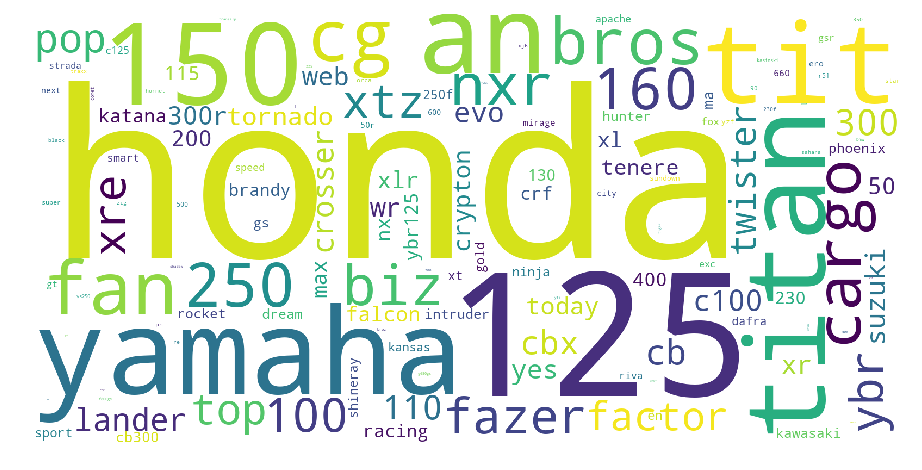

In [48]:
# Exibe a imagem da nova WordCloud gerada
fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

In [49]:
# Exporta para um aquivo
wordcloud.to_file("./imagens/wordcloud_descricoes_final.png")